In [115]:
# importer le notebook des fonctions utiles et des importations nécessaires
import nbimporter
from functions_and_imports import *

In [116]:
data = pd.read_csv('data/df_12H_imputed_with_knn.csv')
display_basic_info(data)

Shape of the DataFrame: (52536, 39)

Number of unique patients: 4378

SepsisLabel class counts:
 0.0    39402
1.0    13134
Name: SepsisLabel, dtype: int64

Number of unique patients per class in 'will_have_sepsis':
 will_have_sepsis
0.0    2189
1.0    2189
Name: Patient_ID, dtype: int64

Columns in the DataFrame:
 Index(['Hour', 'HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'TroponinI', 'Hct', 'PTT', 'WBC', 'Fibrinogen', 'Platelets', 'Age',
       'Gender', 'HospAdmTime', 'SepsisLabel', 'Patient_ID',
       'will_have_sepsis'],
      dtype='object')

Data Types:
 Hour                float64
HR                  float64
O2Sat               float64
Temp                float64
SBP                 float64
MAP                 float64
DBP               

# Split

In [117]:
train_df, test_df = split_train_test_data_v2(data)

In [118]:
[ col for col in test_df.columns if col == "SepsisLabel"]

['SepsisLabel']

# Extraction des séquences et normalisation

In [119]:
normalize_sequences_train, labels_train, normalize_sequences_test, labels_test, scaler = extract_sequences_and_normalize(train_df, test_df, exclude_columns=['Patient_ID', 'Hour', 'SepsisLabel'], drop_column ='will_have_sepsis', label_column='SepsisLabel', id_column='Patient_ID', time_column='Hour', sequence_length=6)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [120]:
normalize_sequences_train.shape,labels_train.shape, normalize_sequences_test.shape,labels_test.shape

((24514, 6, 35), (24514,), (6132, 6, 35), (6132,))

# Modèle

In [121]:
from tensorflow.keras.layers import InputLayer
def build_and_train_lstm_model(X_train, y_train, X_val, y_val, input_shape, epochs=300, batch_size=128):
	"""
	Construit et entraîne un modèle LSTM pour la prédiction basée sur des données séquentielles.

	Args:
	- X_train: Séquences d'entraînement (padded).
	- y_train: Labels d'entraînement.
	- X_val: Séquences de validation (padded).
	- y_val: Labels de validation.
	- input_shape: Tuple représentant la forme des données d'entrée (time_steps, features).
	- epochs: Nombre d'époques d'entraînement.
	- batch_size: Taille du lot pour l'entraînement.

	Returns:
	- keras.models.Model: Modèle LSTM entraîné.
	- keras.callbacks.History: Historique de l'entraînement.
	"""
	model = Sequential([
		InputLayer(input_shape=input_shape),
		LSTM(128, return_sequences=True),
		Dropout(0.25),
		LSTM(64),
		Dropout(0.25),
		Dense(128, activation='relu'),
		Dropout(0.25),
		Dense(1, activation='sigmoid')
	])

	model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

	# Configuration de l'arrêt prématuré
	early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='min', restore_best_weights=True)

	# Entraînement du modèle
	history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping])

	return model, history


# Entrainement 

In [122]:
normalize_sequences_train.shape

(24514, 6, 35)

In [123]:
input_shape = (6, 35)  # time steps, features
model_1, history_1 = build_and_train_lstm_model(normalize_sequences_train, labels_train, normalize_sequences_test, labels_test, input_shape)

Train on 24514 samples, validate on 6132 samples
Epoch 1/300
24514/24514 [==============================] - 6s 264us/sample - loss: 0.6740 - acc: 0.5758 - val_loss: 0.6576 - val_acc: 0.6220
Epoch 2/300
24514/24514 [==============================] - 4s 159us/sample - loss: 0.5896 - acc: 0.6890 - val_loss: 0.5662 - val_acc: 0.7184
Epoch 3/300
24514/24514 [==============================] - 4s 160us/sample - loss: 0.5420 - acc: 0.7313 - val_loss: 0.5464 - val_acc: 0.7374
Epoch 4/300
24514/24514 [==============================] - 4s 158us/sample - loss: 0.5317 - acc: 0.7396 - val_loss: 0.5451 - val_acc: 0.7396
Epoch 5/300
24514/24514 [==============================] - 4s 158us/sample - loss: 0.5264 - acc: 0.7431 - val_loss: 0.5390 - val_acc: 0.7352
Epoch 6/300
24514/24514 [==============================] - 4s 157us/sample - loss: 0.5225 - acc: 0.7461 - val_loss: 0.5390 - val_acc: 0.7394
Epoch 7/300
24514/24514 [==============================] - 4s 157us/sample - loss: 0.5192 - acc: 0.7477 -

In [124]:

def plot_training_history(history):
	"""
	Affiche les courbes de précision et de perte pour les ensembles d'entraînement et de validation.

	Args:
	- history: Historique de l'entraînement du modèle (history object de Keras).
	"""
	# Récupérer les données de l'historique
	accuracy = history.history['acc']
	val_accuracy = history.history['val_acc']
	loss = history.history['loss']
	val_loss = history.history['val_loss']
	epochs = range(1, len(accuracy) + 1)

	# Tracé de la précision
	plt.figure(figsize=(14, 5))

	# Courbe d'accuracy
	plt.subplot(1, 2, 1)
	plt.plot(epochs, accuracy, 'b-', label='Accuracy entraînement')
	plt.plot(epochs, val_accuracy, 'r-', label='Accuracy validation')
	plt.title('Accuracy - Entraînement vs Validation')
	plt.xlabel('Épochs')
	plt.ylabel('Accuracy')
	plt.legend()
	plt.grid(True)

	# Courbe de perte (loss)
	plt.subplot(1, 2, 2)
	plt.plot(epochs, loss, 'b-', label='Perte entraînement')
	plt.plot(epochs, val_loss, 'r-', label='Perte validation')
	plt.title('Perte - Entraînement vs Validation')
	plt.xlabel('Épochs')
	plt.ylabel('Perte')
	plt.legend()
	plt.grid(True)

	plt.tight_layout()
	plt.show()


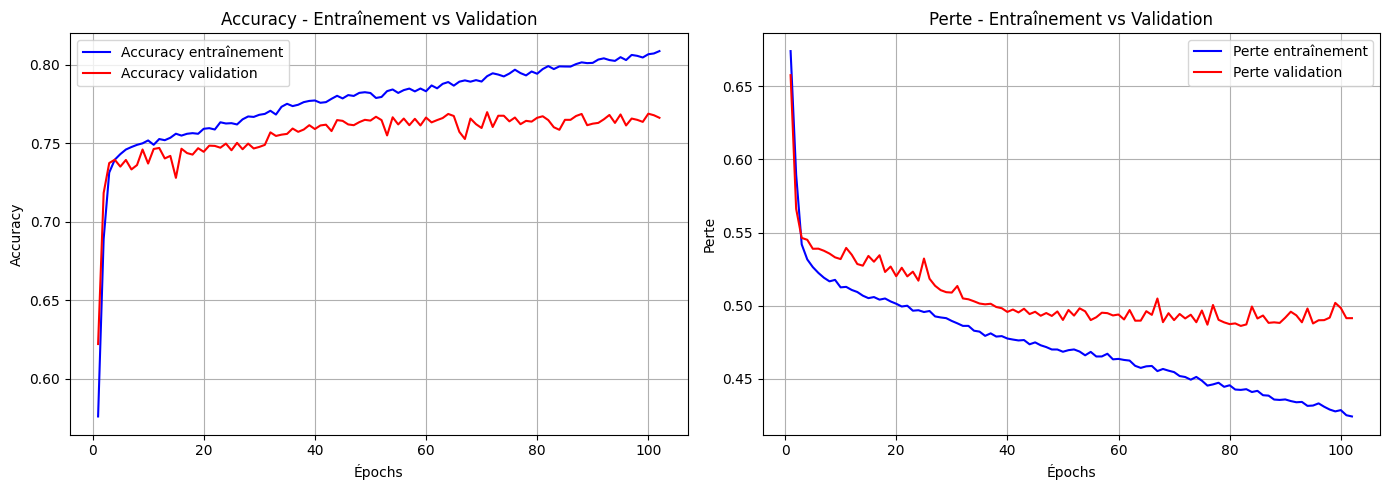

In [125]:
plot_training_history(history_1)

Accuracy: 0.7648
Precision: 0.7304
Recall: 0.7347
F1-Score: 0.7326
AUROC: 0.8450


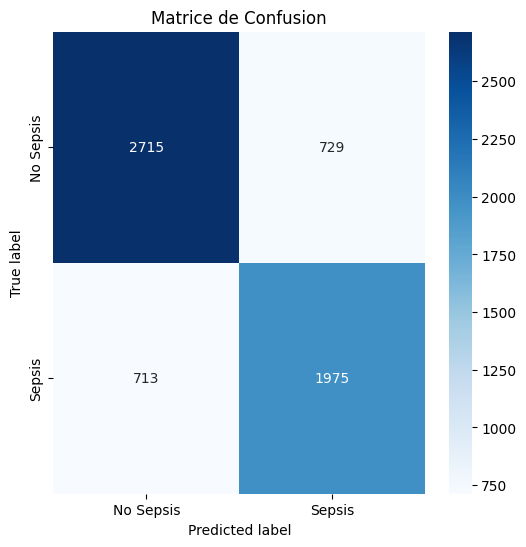

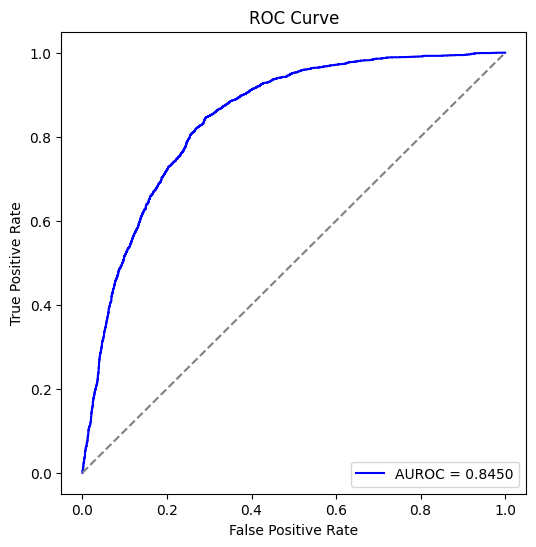

In [126]:
# Évaluer les performances du modèle sur les données de test
predict_prob, predict = evaluate_model_performance(model_1, normalize_sequences_test, labels_test)

In [127]:
import tensorflow as tf


In [128]:
# tf.config.run_functions_eagerly(True)

In [129]:
# tf.compat.v1.disable_eager_execution()

In [130]:
normalize_sequences_test.shape

(6132, 6, 35)

In [131]:
from tensorflow.compat.v1.keras.backend import get_session
tf.compat.v1.disable_v2_behavior()


In [132]:
import shap
import numpy as np

# Explain the model predictions
# Use a small subset of the training data as the background dataset
background_data = normalize_sequences_train[:1000]  # Example: Take the first 100 samples as background

# SHAP deeep explainer
e = shap.DeepExplainer(model_1, background_data)


In [133]:

# Choose a subset of the validation data to explain
data_to_explain = normalize_sequences_test[:300]

# Compute SHAP values
shap_values_all = np.array(e.shap_values(data_to_explain)[0])


In [134]:
shap_values_sepsis_label = shap_values_all[labels_test[:300]>0.5]
print(len(shap_values_sepsis_label))
shap_values_no_sepsis_label = shap_values_all[labels_test[:300]<0.5]
print(len(shap_values_no_sepsis_label))

108
192


In [135]:
predictions = np.array([e[0] for e in model_1.predict(normalize_sequences_test[:300])])

In [136]:
threshold = 0.7
shap_values_sepsis_predicted = shap_values_all[predictions>=threshold]
print(len(shap_values_sepsis_predicted))
shap_values_no_sepsis_predicted = shap_values_all[predictions<threshold]
print(len(shap_values_no_sepsis_predicted))

82
218


In [137]:
features = [col for col in train_df.columns if col not in ['Patient_ID', 'Hour', 'SepsisLabel', 'will_have_sepsis']]

In [138]:
shap_values_sepsis_label.shape

(108, 6, 35)

In [139]:
import matplotlib.pyplot as plt
import numpy as np

# Aggregate across features
feature_importance_over_time = shap_values_all.reshape(-1, 35)

feature_importance_over_time_sepsis_label = shap_values_sepsis_label.reshape(-1, 35)
feature_importance_over_time_no_sepsis_label = shap_values_no_sepsis_label.reshape(-1, 35)
feature_importance_over_time_sepsis_predicted = shap_values_sepsis_predicted.reshape(-1, 35)
feature_importance_over_time_no_sepsis_predicted = shap_values_no_sepsis_predicted.reshape(-1, 35)


In [140]:
feature_importance_over_time.shape

(1800, 35)

In [141]:
shap_values_sepsis_label[1][0][2]

0.0725569959962201

In [142]:
feature_importance_over_time_sepsis_label[6][2]

0.0725569959962201

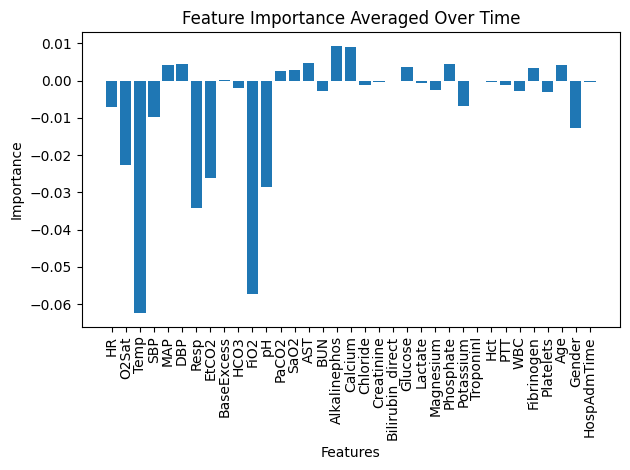

In [143]:
import matplotlib.pyplot as plt

for patient in feature_importance_over_time[:1]:
	plt.bar(features, patient)

	plt.xticks(rotation=90)  # Rotate x-axis labels vertically
	plt.xlabel('Features')
	plt.ylabel('Importance')
	plt.title('Feature Importance Averaged Over Time')
	plt.tight_layout()  # Ensure everything fits within the figure
	plt.show()

In [144]:
feature_importance_over_time.shape

(1800, 35)

In [145]:
df_feature_importance_over_time = pd.DataFrame(feature_importance_over_time, columns=features)
df_feature_importance_over_time_sepsis_label = pd.DataFrame(feature_importance_over_time_sepsis_label, columns=features)
df_feature_importance_over_time_no_sepsis_label = pd.DataFrame(feature_importance_over_time_no_sepsis_label, columns=features)
df_feature_importance_over_time_sepsis_predicted = pd.DataFrame(feature_importance_over_time_sepsis_predicted, columns=features)
df_feature_importance_over_time_no_sepsis_predicted = pd.DataFrame(feature_importance_over_time_no_sepsis_predicted, columns=features)

In [146]:
df_feature_importance_over_time

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,...,Potassium,TroponinI,Hct,PTT,WBC,Fibrinogen,Platelets,Age,Gender,HospAdmTime
0,-0.006989,-0.022546,-0.062470,-0.009840,0.004083,0.004348,-0.034342,-0.026165,0.000274,-0.002009,...,-0.006845,1.947124e-07,-0.000415,-0.001180,-0.002690,0.003261,-0.002975,0.004270,-0.012765,-0.000372
1,-0.005299,-0.013263,-0.031243,0.002225,-0.001612,-0.000953,-0.013408,0.008045,0.000323,-0.000353,...,-0.007905,7.216080e-07,-0.000401,-0.001233,0.001180,0.004834,-0.000457,-0.000893,-0.005831,-0.000288
2,-0.003548,-0.006689,-0.004974,-0.008257,-0.000597,-0.003191,-0.007070,0.003523,0.000385,-0.000410,...,-0.007778,1.457105e-06,-0.000262,-0.001035,0.000451,0.005188,-0.000214,-0.004144,-0.003028,-0.000189
3,-0.002311,-0.002991,0.000145,-0.001137,-0.000638,-0.001310,-0.002999,0.002128,0.000375,-0.000334,...,-0.005603,1.030609e-06,-0.000012,-0.000681,0.000257,0.004493,0.000159,-0.004645,-0.001492,-0.000107
4,-0.001271,-0.000687,0.000952,-0.000969,-0.000486,-0.001567,-0.000994,0.000028,0.000201,-0.000225,...,-0.003307,4.378375e-07,0.000088,-0.000424,0.000122,0.002975,0.000123,-0.003456,-0.000841,-0.000051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1795,-0.003426,-0.012076,-0.003011,0.000212,-0.000743,-0.000688,-0.031412,-0.012441,-0.000846,-0.000161,...,-0.003353,5.299437e-07,-0.000256,-0.003433,0.003352,0.000054,-0.008357,-0.001995,-0.006307,-0.000162
1796,-0.002541,-0.006055,-0.000647,-0.001260,-0.000548,-0.001335,-0.016169,0.002007,-0.000447,-0.000309,...,-0.006063,1.083709e-06,-0.000291,-0.002280,0.001590,0.000760,-0.002799,-0.004485,-0.003474,-0.000119
1797,-0.001239,-0.001580,-0.000085,-0.000100,-0.000307,-0.001838,-0.006753,0.001165,-0.000372,-0.000286,...,-0.004263,7.357582e-07,-0.000180,-0.001199,0.000831,0.000639,-0.000736,-0.004576,-0.001963,-0.000082
1798,-0.000955,-0.001007,-0.000046,-0.000270,-0.000413,-0.001710,-0.002103,0.000119,-0.000202,-0.000230,...,-0.002738,3.034431e-07,-0.000038,-0.000686,0.000466,0.000021,0.000033,-0.003288,-0.001094,-0.000055


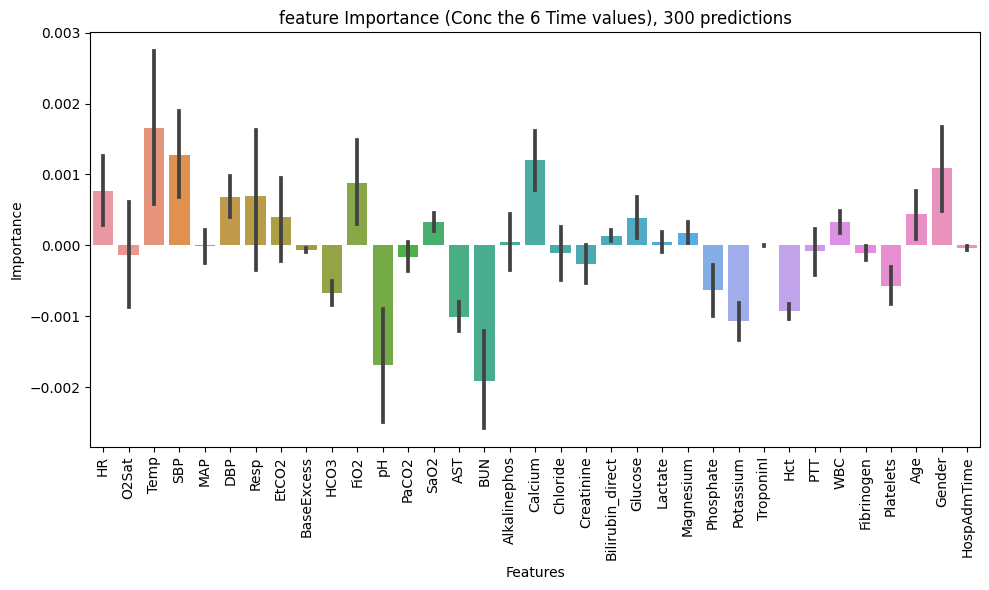

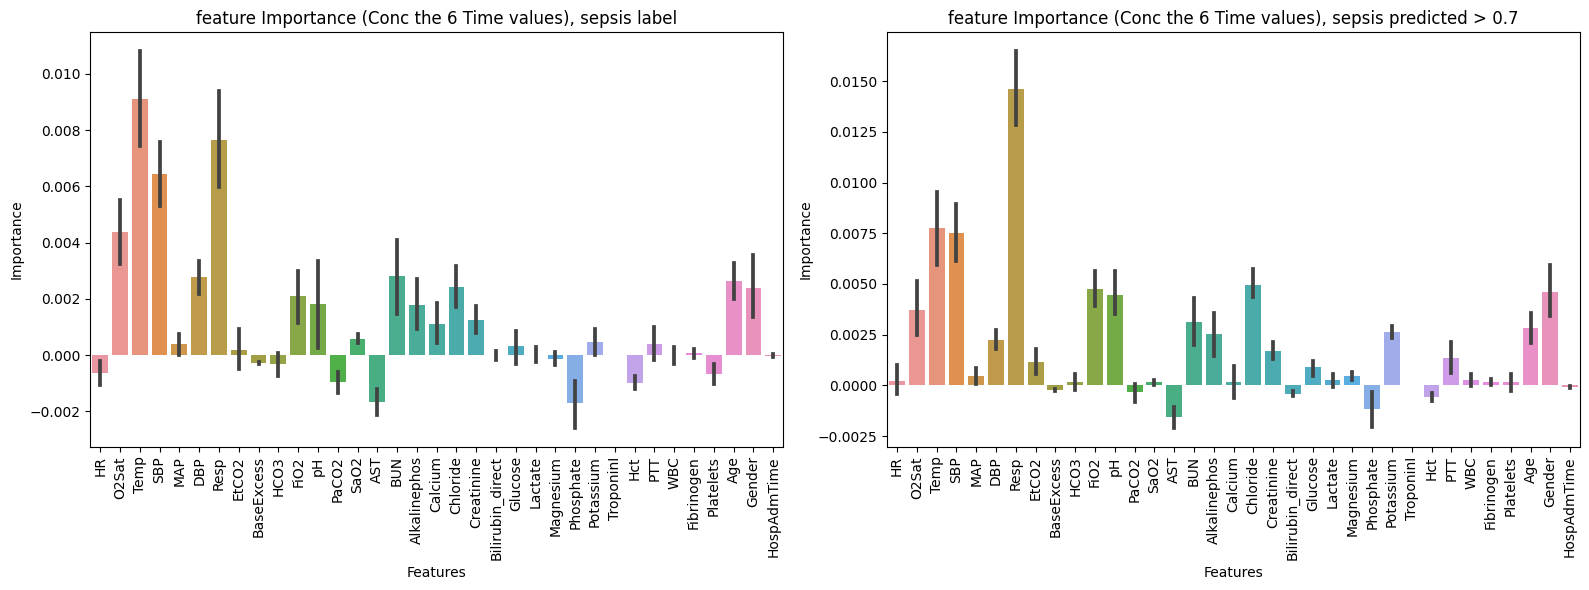

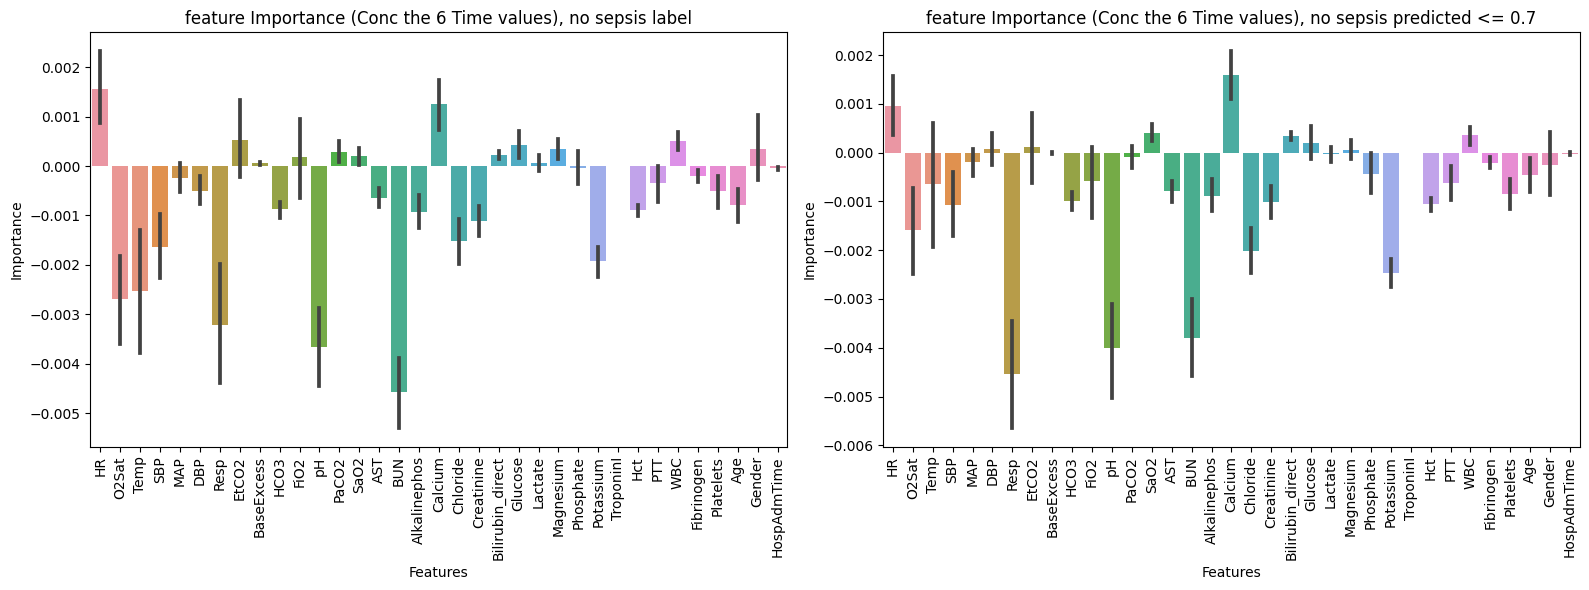

In [147]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create the first figure (Fig 1)
plt.figure(figsize=(10, 6))
sns.barplot(data=df_feature_importance_over_time)
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('feature Importance (Conc the 6 Time values), 300 predictions')
plt.tight_layout()
plt.show()

# Create the second figure with Figs 2 and 4 side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.barplot(data=df_feature_importance_over_time_sepsis_label, ax=axes[0])
axes[0].set_xticks(axes[0].get_xticks())
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)
axes[0].set_xlabel('Features')
axes[0].set_ylabel('Importance')
axes[0].set_title('feature Importance (Conc the 6 Time values), sepsis label')

sns.barplot(data=df_feature_importance_over_time_sepsis_predicted, ax=axes[1])
axes[1].set_xticks(axes[1].get_xticks())
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)
axes[1].set_xlabel('Features')
axes[1].set_ylabel('Importance')
axes[1].set_title('feature Importance (Conc the 6 Time values), sepsis predicted > '+str(threshold))

plt.tight_layout()
plt.show()

# Create the third figure with Figs 3 and 5 side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.barplot(data=df_feature_importance_over_time_no_sepsis_label, ax=axes[0])
axes[0].set_xticks(axes[0].get_xticks())
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)
axes[0].set_xlabel('Features')
axes[0].set_ylabel('Importance')
axes[0].set_title('feature Importance (Conc the 6 Time values), no sepsis label')

sns.barplot(data=df_feature_importance_over_time_no_sepsis_predicted, ax=axes[1])
axes[1].set_xticks(axes[1].get_xticks())
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)
axes[1].set_xlabel('Features')
axes[1].set_ylabel('Importance')
axes[1].set_title('feature Importance (Conc the 6 Time values), no sepsis predicted <= '+str(threshold))

plt.tight_layout()
plt.show()


In [148]:
def extract_sequences(test_df, exclude_columns=['Patient_ID', 'Hour', 'SepsisLabel'], label_column='SepsisLabel', id_column='Patient_ID', time_column='Hour', sequence_length=6):
	"""
	Prépare les données d'entraînement et de test pour l'extraction de séquences
	"""
	# column will_have_sepsis is dropped earlier in the notebook, so no attempt is made here.
	# Sélectionner les colonnes de caractéristiques
	feature_cols = [col for col in train_df.columns if col not in exclude_columns]

	return extract_sequences_and_labels(
		test_df, id_column, time_column, feature_cols, label_column, sequence_length
	)

In [149]:
original_sequences, _ = extract_sequences(test_df, exclude_columns=['Patient_ID', 'Hour', 'Sepsispredicted','SepsisLabel'], label_column='SepsisLabel', id_column='Patient_ID', time_column='Hour', sequence_length=6)

In [198]:
for i in mpl.colormaps.keys():
    print(i)

magma
inferno
plasma
viridis
cividis
twilight
twilight_shifted
turbo
Blues
BrBG
BuGn
BuPu
CMRmap
GnBu
Greens
Greys
OrRd
Oranges
PRGn
PiYG
PuBu
PuBuGn
PuOr
PuRd
Purples
RdBu
RdGy
RdPu
RdYlBu
RdYlGn
Reds
Spectral
Wistia
YlGn
YlGnBu
YlOrBr
YlOrRd
afmhot
autumn
binary
bone
brg
bwr
cool
coolwarm
copper
cubehelix
flag
gist_earth
gist_gray
gist_heat
gist_ncar
gist_rainbow
gist_stern
gist_yarg
gnuplot
gnuplot2
gray
hot
hsv
jet
nipy_spectral
ocean
pink
prism
rainbow
seismic
spring
summer
terrain
winter
Accent
Dark2
Paired
Pastel1
Pastel2
Set1
Set2
Set3
tab10
tab20
tab20b
tab20c
magma_r
inferno_r
plasma_r
viridis_r
cividis_r
twilight_r
twilight_shifted_r
turbo_r
Blues_r
BrBG_r
BuGn_r
BuPu_r
CMRmap_r
GnBu_r
Greens_r
Greys_r
OrRd_r
Oranges_r
PRGn_r
PiYG_r
PuBu_r
PuBuGn_r
PuOr_r
PuRd_r
Purples_r
RdBu_r
RdGy_r
RdPu_r
RdYlBu_r
RdYlGn_r
Reds_r
Spectral_r
Wistia_r
YlGn_r
YlGnBu_r
YlOrBr_r
YlOrRd_r
afmhot_r
autumn_r
binary_r
bone_r
brg_r
bwr_r
cool_r
coolwarm_r
copper_r
cubehelix_r
flag_r
gist_earth_r
g

In [268]:
import matplotlib.patheffects as path_effects

def draw_patient_pred(data_array, text_array):

	plt.figure(figsize=(70, 6))  # Adjust the figure size as needed
	ax = sns.heatmap(data_array, annot=text_array, xticklabels=features, fmt=".2f", annot_kws={"color": "black", "fontsize": 22},
                  cmap="seismic", cbar=True, # need to outline and fix colors depending on cmap picked
                  cbar_kws={"shrink": 1.5, "aspect": 10, "label": "shap value (feature impact on sepsis prediction)"}, vmin=-0.12, vmax=0.12) # forcing symetrical spread to be centered on 0, .12 picked arbitrarily (abs max of test sub-dataset shap values is .17, but seems like rare values that should be looked at precisely anyway?)
	ax.figure.axes[-1].yaxis.label.set_size(15) # trick to make color bar label readable https://stackoverflow.com/questions/48586738/seaborn-heatmap-colorbar-label-font-size

	# outline values text
	# for text in ax.texts:  # `ax.texts` contains all annotations
	# 	text.set_path_effects([
	# 		path_effects.Stroke(linewidth=4, foreground='white'),  # Black outline
	# 		path_effects.Normal()  # Normal text appearance
	# 	])

	ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right", fontsize=24)
	ax.xaxis.set_ticks_position("top")  # Place x-ticks on top
	ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

	plt.show()

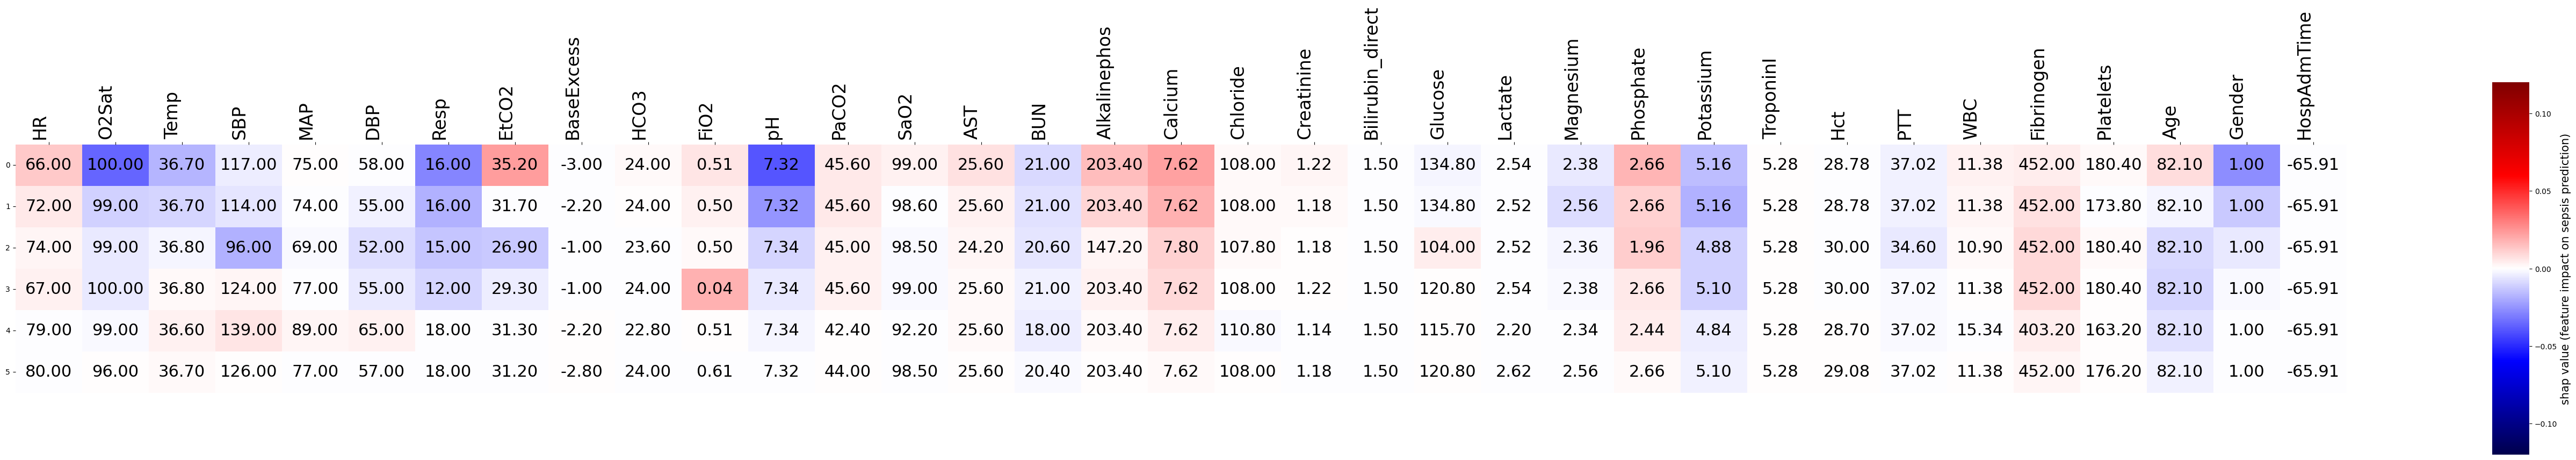

In [269]:
i = 3
data_array = shap_values_all[i]
text_array = original_sequences[i]
draw_patient_pred(data_array, text_array)